In [44]:
import openmc
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

In [45]:
def getArray(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    firstEntry = leakOut.loc[leakOut["mesh 1"]["x"] == 1].loc[leakOut["mesh 1"]["y"] == 1]
    EVals   = list(firstEntry["energy low [eV]"]) + [list(firstEntry["energy high [eV]"])[-1]]
    eMidVec = [(EVals[i]+EVals[i+1])*0.5 for i in range(len(EVals)-1)]

    array = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    for i,eMid in enumerate(eMidVec):
        E_specific = leakOut.loc[leakOut["energy low [eV]"] < eMid]\
                            .loc[leakOut["energy high [eV]"] > eMid]
        if list(E_specific["energy low [eV]"])[0] <= 1.0 and \
           list(E_specific["energy high [eV]"])[0] >= 1.0: continue
        array[i] = E_specific["mean"]
    return array,eMidVec

In [46]:
def plotArray(array,vmax=None):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    if vmax:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1],vmin=0,vmax=vmax)
    else:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1])
    plt.ylabel('Energy [eV]')
    plt.xlabel('Space [normalized]')
    desiredEPoints = np.linspace(0.0,1.2,13)
    desiredEPoints_shifted = [2*val/max(desiredEPoints) - 1.0 for val in desiredEPoints]
    desiredEPoints = ['%.1f'%val for val in desiredEPoints]
    ax.set_yticks(desiredEPoints_shifted);
    ax.set_yticklabels(desiredEPoints[::-1]);
    

In [47]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

# numESpaceFilters = [\
#                     [100,100],
#                     [10,10],
#                     [30,10],
#                     [50,70],
#                    ]
batchesVec = [5,10,20]


filterPair = [50,70]

particles = 1e7
#batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

for batches in batchesVec:
    leakDF_vec = []
    for name in names:
        numEFilter,numSpaceFilter = filterPair

        runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
        pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

        sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
        leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
        leakDF_vec.append(leakDF)
        
    leakDF0  = leakDF_vec[0]
    leakDF1  = leakDF_vec[1]
    leakDF2  = leakDF_vec[2]

    array0,Evals0 = getArray(leakDF0)
    array1,Evals1 = getArray(leakDF1)
    array2,Evals2 = getArray(leakDF2)

    # plotArray(array0)
    # plotArray(array1)
    # plotArray(array2)
    

    error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array1!=0)            # # This is giving rel. error
    error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                        out=np.zeros_like(array0),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error
    error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error

    integratedError12 = np.trapz(np.trapz(error12,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError01 = np.trapz(np.trapz(error01,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError02 = np.trapz(np.trapz(error02,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    diff_True_WrongSAB.append(integratedError12)
    diff_noSAB_True.append(integratedError01)
    diff_noSAB_WrongSAB.append(integratedError02)

Text(0.5, 0, 'Num Batches')

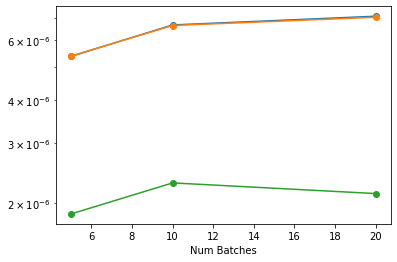

In [48]:
plt.plot(batchesVec,diff_noSAB_True,'o-')
plt.plot(batchesVec,diff_noSAB_WrongSAB,'o-')
plt.plot(batchesVec,diff_True_WrongSAB,'o-')
plt.yscale('log')
plt.xlabel('Num Batches')

In [70]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

filterPairs = [[10,10],[20,20],[40,40],[60,60],[80,80],[100,100],[120,120]]
particles = 5e7
batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

for filterPair in filterPairs:
    leakDF_vec = []
    for name in names:
        numEFilter,numSpaceFilter = filterPair

        runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
        pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

        sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
        leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
        leakDF_vec.append(leakDF)
        
    leakDF0  = leakDF_vec[0]
    leakDF1  = leakDF_vec[1]
    leakDF2  = leakDF_vec[2]

    array0,Evals0 = getArray(leakDF0)
    array1,Evals1 = getArray(leakDF1)
    array2,Evals2 = getArray(leakDF2)

    error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array1!=0)            # # This is giving rel. error
    error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                        out=np.zeros_like(array0),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error
    error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error

    integratedError12 = np.trapz(np.trapz(error12,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError01 = np.trapz(np.trapz(error01,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError02 = np.trapz(np.trapz(error02,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    diff_True_WrongSAB.append(integratedError12)
    diff_noSAB_True.append(integratedError01)
    diff_noSAB_WrongSAB.append(integratedError02)

Text(0.5, 0, 'Num Energy&Spatial Filters')

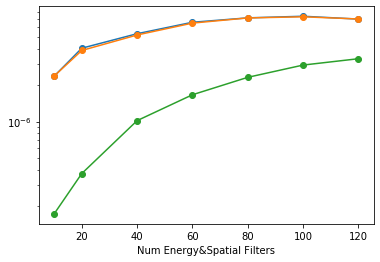

In [71]:
plt.plot([val[0] for val in filterPairs],diff_noSAB_True,'o-')
plt.plot([val[0] for val in filterPairs],diff_noSAB_WrongSAB,'o-')
plt.plot([val[0] for val in filterPairs],diff_True_WrongSAB,'o-')
plt.yscale('log')
plt.xlabel('Num Energy&Spatial Filters')